## 코드 실행환경

Google Colab

Sklearn 버전: 1.2.2

Pandas 버전: 1.5.3

Numpy 버전: 1.23.5

런타임 유형 : CPU

In [37]:
import platform
platform.platform()

'Linux-5.15.120+-x86_64-with-glibc2.35'

In [38]:
!cat /etc/issue.net

Ubuntu 22.04.2 LTS


In [39]:
!python --version

Python 3.10.12


In [40]:
import sklearn
import pandas as pd
import numpy as np

print("Scikit-learn 버전:", sklearn.__version__)
print("Pandas 버전:", pd.__version__)
print("NumPy 버전:", np.__version__)

Scikit-learn 버전: 1.2.2
Pandas 버전: 1.5.3
NumPy 버전: 1.23.5


### 구글 코랩 사용시 구글 드라이브 연결 사용

In [5]:
#구글 드라이브 연결
from google.colab import drive
drive.mount('/content/drive')

#코랩 환경 경로 설정 -> 자신에게 맞는 경로로 설정해주시면 됩니다
DATA_PATH = './'

ModuleNotFoundError: No module named 'google.colab'

In [6]:
DATA_PATH = './'

## Import & Install

In [7]:
# 코랩 기준 필요 라이브러리 설치

#!pip install catboost
#!pip install optuna

In [8]:
# Base & visualization
import pandas as pd
import random
import glob
import os
import numpy as np
import warnings
import matplotlib.pylab as plt
import seaborn as sns

# sklearn module & utils
from tqdm import tqdm
from sklearn.model_selection import KFold
from sklearn.metrics import mean_absolute_error

# Encoding
from sklearn.preprocessing import LabelEncoder

# Modeling
from xgboost.sklearn import XGBRegressor
#from catboost import CatBoostRegressor
from lightgbm import early_stopping, log_evaluation, LGBMRegressor


#Scaling
#from sklearn.preprocessing import StandardScaler, MinMaxScaler, RobustScaler

# optuna
#import optuna
#from optuna.samplers import TPESampler

pd.set_option('display.max_columns', 30)
pd.set_option('display.max_rows', 100)

## Fix Seed

In [9]:
class CFG:
    SEED = 0

def seed_everything(seed):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)

seed_everything(CFG.SEED) # Seed 고정

## Data Load

In [10]:
train_paths = glob.glob(DATA_PATH +'train/*.csv')
test_paths = glob.glob(DATA_PATH + 'test/*.csv')

In [11]:
# 성능 재현을 위한 데이터의 로드 순서 고정
train_paths.sort()
test_paths.sort()

In [14]:
temp = pd.DataFrame()
temp['path'] = train_paths
temp2 = pd.DataFrame()
temp2['path'] = test_paths

In [15]:
train_paths = list(temp.path.apply(lambda x:x.replace('\\','/')))
test_paths = list(temp2.path.apply(lambda x:x.replace('\\','/')))

## EDA

In [26]:
train_eda = pd.DataFrame()
for i in range(len(train_paths)):
    temp_df = pd.read_csv(train_paths[i])
    train_eda = pd.concat([train_eda,temp_df],axis = 0)

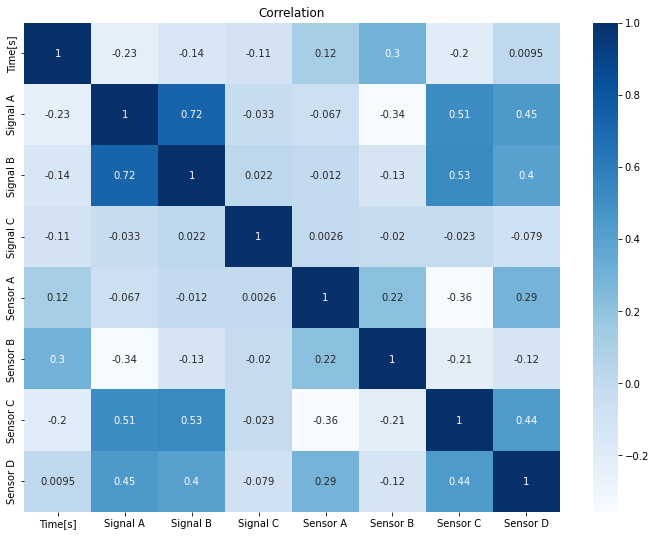

In [28]:
import seaborn as sns
import matplotlib.pylab as plt
plt.figure(figsize = (12,9))
g = sns.heatmap(train.corr(),annot=True, cmap='Blues')
g.set_title("Correlation")
plt.show()

KeyboardInterrupt: 

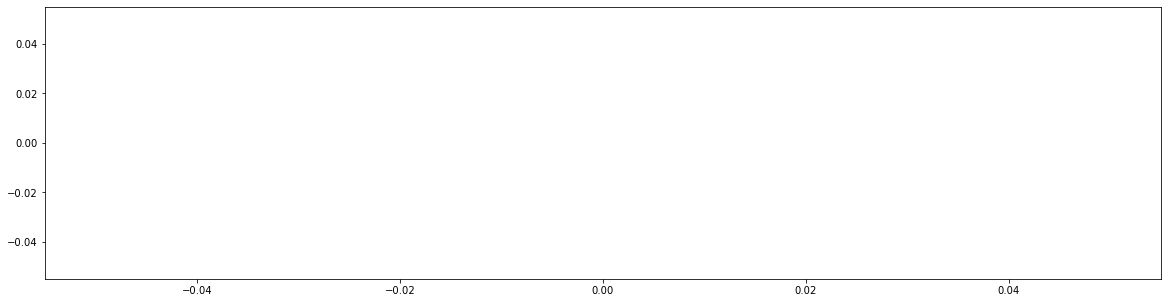

In [29]:
#시각화 
plt.figure(figsize=(20, 5))
sns.lineplot(x=train['Time[s]'], y=train['Signal A'], data=train, label='Precipitation Temp', color = '#5882FA')

plt.title('Signal A',fontsize=20)
plt.xlabel('Time[s]',fontsize=17)
plt.xticks(fontsize = 15 , rotation = 30)
plt.ylabel('Signal A',fontsize=20)
plt.legend()
plt.grid(True)
plt.show()

In [ ]:
plt.figure(figsize=(20, 5))
sns.lineplot(x=train['Time[s]'], y=train['Signal B'], data=train, label='Precipitation Temp', color = '#FF0000')

plt.title('Signal B',fontsize=20)
plt.xlabel('Time[s]',fontsize=17)
plt.xticks(fontsize = 15 , rotation = 30)
plt.ylabel('Signal B',fontsize=20)
plt.legend()
plt.grid(True)
plt.show()

In [ ]:
plt.figure(figsize=(20, 5))
sns.lineplot(x=train['Time[s]'], y=train['Signal C'], data=train, label='Precipitation Temp', color = '#0000FF')

plt.title('Signal C',fontsize=20)
plt.xlabel('Time[s]',fontsize=17)
plt.xticks(fontsize = 15 , rotation = 30)
plt.ylabel('Signal C',fontsize=20)
plt.legend()
plt.grid(True)
plt.show()

In [ ]:
plt.figure(figsize=(20, 5))
sns.lineplot(x=train['Time[s]'], y=train['Sensor A'], data=train, label='Precipitation Temp', color = '#4B0082')

plt.title('Sensor A',fontsize=20)
plt.xlabel('Time[s]',fontsize=17)
plt.xticks(fontsize = 15 , rotation = 30)
plt.ylabel('Sensor A',fontsize=20)
plt.legend()
plt.grid(True)
plt.show()

In [ ]:
plt.figure(figsize=(20, 5))
sns.lineplot(x=train['Time[s]'], y=train['Sensor B'], data=train, label='Precipitation Temp', color = '#008B8B')

plt.title('Sensor B',fontsize=20)
plt.xlabel('Time[s]',fontsize=17)
plt.xticks(fontsize = 15 , rotation = 30)
plt.ylabel('Sensor B',fontsize=20)
plt.legend()
plt.grid(True)
plt.show()

In [ ]:
plt.figure(figsize=(20, 5))
sns.lineplot(x=train['Time[s]'], y=train['Sensor C'], data=train, label='Precipitation Temp', color = '#808000')

plt.title('Sensor C',fontsize=20)
plt.xlabel('Time[s]',fontsize=17)
plt.xticks(fontsize = 15 , rotation = 30)
plt.ylabel('Sensor C',fontsize=20)
plt.legend()
plt.grid(True)
plt.show()

## Feature Engineering

In [47]:
extremes = {
    'Time': {'min': float('inf'), 'max': float('-inf')},
    'Signal A': {'min': float('inf'), 'max': float('-inf')},
    'Signal B': {'min': float('inf'), 'max': float('-inf')},
    'Signal C': {'min': float('inf'), 'max': float('-inf')},
    'Sensor A': {'min': float('inf'), 'max': float('-inf')},
    'Sensor B': {'min': float('inf'), 'max': float('-inf')},
    'Sensor C': {'min': float('inf'), 'max': float('-inf')},
    'Sensor D': {'min': float('inf'), 'max': float('-inf')}
}

# 주어진 모든 경로에 대해 반복
for path in train_paths:
    data = pd.read_csv(path)
    data = data.rename(columns={'Time[s]': 'Time'})

    # 각 열에 대해 최소값과 최대값 업데이트
    for column in extremes.keys():
        extremes[column]['min'] = min(extremes[column]['min'], data[column].min())
        extremes[column]['max'] = max(extremes[column]['max'], data[column].max())

In [ ]:
train_data = []
test_data = []

for path in tqdm(train_paths):
    data = pd.read_csv(path)
    data = data.rename(columns={'Time[s]': 'Time'}) # 특수문자 제거

    driver = str(path.split('/')[-1].split('.')[0].split('_')[1][0])
    data['driver'] = 0 if driver == 'A' else 1

    label = float(path.split('/')[-1].split('.')[0].split('_')[0][:-2])
    data['label'] = label

    for i, key in enumerate(extremes.keys()):
        data[key] = (data[key] - extremes[key]['min']) / (extremes[key]['max'] - extremes[key]['min']) # 스케일링 진행

    window = 500
    data = [data[i:i+window] for i in range(0, len(data), window)] # 시계열성 반영을 위해 500개씩 Slice

    train_data.append(data)

for path in tqdm(test_paths):
    data = pd.read_csv(path)
    data = data.rename(columns={'Time[s]': 'Time'}) # 특수문자 제거

    driver = str(path.split('/')[-1].split('.')[0].split('_')[1][0])
    data['driver'] = 0 if driver == 'A' else 1

    name = str(path.split('/')[-1].split('_')[0])
    data['ID'] = name

    for i, key in enumerate(extremes.keys()):
        data[key] = (data[key] - extremes[key]['min']) / (extremes[key]['max'] - extremes[key]['min']) # 스케일링 진행

    test_data.append(data)

  1%|          | 41/4048 [00:10<25:32,  2.61it/s]

In [ ]:
# 각 Train csv별 Slice된 갯수
for i in range(len(train_data)):
  print(i, ':', len(train_data[i]))

## Train_Validation_split

In [ ]:
# Train.csv별 균일하게 validation을 구축

split_ratio = 0.8

X_train = []
X_val = []
for i in range(len(train_data)):
    np.random.seed(CFG.SEED)
    np.random.shuffle(train_data[i])

    split_index = int(len(train_data[i]) * split_ratio)
    X_train.append(pd.concat(train_data[i][:split_index]))
    X_val.append(pd.concat(train_data[i][split_index:]))

In [ ]:
X_train = pd.concat(X_train).reset_index(drop=True)
X_val = pd.concat(X_val).reset_index(drop=True)

test = pd.concat(test_data).reset_index(drop=True)

In [ ]:
y_train = X_train['label']
y_val = X_val['label']

X_train = X_train.drop(columns='label')
X_val = X_val.drop(columns='label')

In [ ]:
test_id = test['ID']
test = test.drop(columns='ID')

## Modeling

In [ ]:
model = LGBMRegressor(n_estimators=100000, learning_rate=0.1, random_state=CFG.SEED, num_leaves=65)
model.fit(X_train, y_train, eval_set=(X_val,y_val), eval_metric='mae', callbacks=[early_stopping(stopping_rounds=1000), log_evaluation(1000)])
pred = model.predict(X_val)
pred = np.clip(pred, 0, np.inf)

mae = mean_absolute_error(y_val, pred)

print(f'MAE는 {mae}')

In [ ]:
sub_pred = model.predict(test)
sub_pred = np.clip(sub_pred, 0, np.inf)
sub_pred = np.array(sub_pred)

In [ ]:
test['ID'] = test_id
test['weight'] = sub_pred

## Submission

In [ ]:
submit= pd.read_csv(DATA_PATH + 'sample_submission.csv')['ID']

In [ ]:
test_pivot = pd.pivot_table(test, values = 'weight', index='ID', aggfunc=lambda x: np.percentile(x, 24.5)).reset_index()

In [ ]:
submission = pd.merge(submit, test_pivot, how='left', on='ID')

In [ ]:
submission['weight'] = submission['weight'].apply(lambda x: round(x, -2))

In [ ]:
submission.to_csv(DATA_PATH + 'Final_submission.csv', index=False)